In [3]:
import re
import nltk
import time
import requests
import scrapy
import numpy as np
import pandas as pd
from textblob import TextBlob, Word
from scrapy.http import TextResponse
from nltk.corpus import stopwords, wordnet

### 1) Scrape all the latest news headings (and publication time) from https://www.tert.am/en
and answer the following questions:<br>
- What are the top most frequent words? (not stopword),<br>
- How many typical Armenian surnames can be counted in titles? (assume surname in
any word starting with an uppercase and ending with “yan”),<br>
- In what part of the day are most of the articles published? (you may provide some
range such as from 10am to 11am).

In [4]:
url = "https://www.tert.am/en"
response = requests.get(url)
response = TextResponse(url = response.url, body = response.text, encoding = "utf-8")
headings=response.css("ul[class='list list--with-scroll scroller-block show-link-visited']>li>div>a>span[class='list__title db']::text").extract()
publication_time=response.css("span[class='list__date db fb fs14']::text").extract()
print(len(headings)==len(publication_time))##checking whether we scraped correctly


True


In [5]:
data=pd.DataFrame({"News":headings,"Time":publication_time})##
print(data.head())

                                                News           Time
0      South Korea warns Japan of security pact risk  14:59 • 03/08
1  Angelina Jolie shows off her extensive tattoos...  14:36 • 03/08
2  Nagorno-Karabakh reports 900 Azerbaijani cease...  14:17 • 03/08
3  Google lets rivals bid to power Android search...  14:04 • 03/08
4  Armenian tourism official calls for developing...  13:37 • 03/08


In [6]:
text=TextBlob(" ".join(data.News.tolist()))
sw = stopwords.words('english') #stopwords in english

In [7]:
cleaned=[i for i in text.words if i.lower() not in sw and len(i)>1] ##cleaning stopwords and nonwords

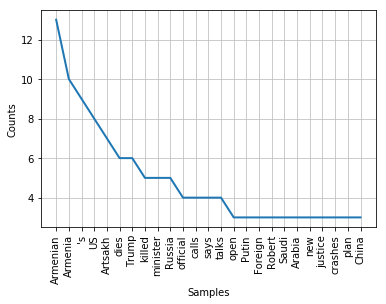

In [9]:
freq=nltk.FreqDist(cleaned)
freq.plot(25)

b) How many typical Armenian surnames can be counted in titles? (assume surname in
any word starting with an uppercase and ending with “yan”),

In [11]:
surnames=re.findall("[A-Z][a-z]+yan",text.string)
print(surnames)
##the answer is 6

['Davtyan', 'Kocharyan', 'Soghoyan', 'Ghazanchyan', 'Kocharyan', 'Kocharyan']


c) In what part of the day are most of the articles published? (you may provide some
range such as from 10am to 11am).

In [12]:
data.Time.apply(lambda x:x[:3]).value_counts()
## as you see most(13) articles are published from 12:00 to 13:00

12:    13
14:    12
11:    12
10:    12
15:    11
09:    10
17:    10
13:     9
16:     7
18:     4
Name: Time, dtype: int64

### 2) Scrape all jobs and companies from https://staff.am/en/jobs and answer the following
questions:<br>
- Which company has the highest number of job postings?<br>
- How many postings does this company have?<br>
- Which company has the highest number of “developer” (or related) job postings?<br>

In [13]:
def get_data(url):
    response = requests.get(url)
    response = TextResponse(url = response.url, body = response.text, encoding = "utf-8")
    company=response.css("p.job_list_company_title::text").extract()
    job=response.css("p.font_bold::text").extract()
    return company,job

In [14]:
links=["https://staff.am/en/jobs?page={}&per-page=50".format(i) for i in range(1,13)]

In [15]:
companies=[]
jobs=[]
for i in links:
    company,job=get_data(i)
    companies.extend(company)
    jobs.extend(job)

In [16]:
data=pd.DataFrame({"Company":companies,"Job":jobs})
print(data.head())

                                Company                    Job
0            Kidoo Fun and Smart Garden                   Cook
1            Kidoo Fun and Smart Garden                Teacher
2                         InterTech LLC  Poker Product Manager
3                         InterTech LLC     Promotions Manager
4  Web Apricot Internet Services Agency      Laravel developer


In [18]:
data.Company.value_counts()[:5]
##this answers to the questions a) and b)

ՀՀ կրթության, գիտության, մշակույթի և սպորտի նախարարություն    34
Synopsys Armenia                                              33
Digitain                                                      22
PicsArt                                                       16
BetConstruct                                                  15
Name: Company, dtype: int64

Which company has the highest number of “developer” (or related) job postings?

In [22]:
data[data.Job.str.lower().str.contains("developer")]["Company"].value_counts()[:5]

HelpSystems Armenia                     5
Web Apricot Internet Services Agency    4
BetConstruct                            4
Alternative Creative Network            3
Simonian Educational Foundation         3
Name: Company, dtype: int64

### 3) Scrape the table with exchange rates from rates.am for the first 2 weeks of July (can be
done both with and without Selenium).
- What is the average USD rate for this duration?
- Plot the average daily USD rate over time.

In [23]:
url="http://www.rate.am/am/armenian-dram-exchange-rates/banks/non-cash/2019/07/02/20-00"

In [24]:
def get_table(url):
    """The following function get the data anc remove unnecessary columns and rows"""
    lst=pd.read_html(url)
    time.sleep(3)
    table=lst[3]
    table.drop(table.columns[[0, 2,13,14]], axis=1, inplace=True)
    data=table[1:19]
    final_data=data.rename(columns=data.iloc[0])[1:]
    final_data.reset_index(drop=True,inplace=True)
    return final_data

In [25]:
links=["http://www.rate.am/am/armenian-dram-exchange-rates/banks/non-cash/2019/07/{0:02d}/20-00".format(i) for i in range(1,15)]

In [26]:
alltables=[]
for i in links:
    alltables.append(get_table(i))

In [27]:
data=pd.concat(alltables,ignore_index=True) ## this command concates all tables
data.head()

,Բանկ,Մասնաճյուղեր,Ամսաթիվ,Առք,Վաճ.,Առք,Վաճ.,Առք,Վաճ.,Առք,Վաճ.
0,ԱԿԲԱ-ԿՐԵԴԻՏ ԱԳՐԻԿՈԼ ..,59,"01 Հլս, 20:01",475,478.50,536,545,7.51,7.65,596,610
1,Էյչ-Էս-Բի-Սի Բանկ,9,"01 Հլս, 20:01",475.50,478.50,537,544,7.47,7.64,599,607
2,Բիբլոս Բանկ Արմենիա,5,"01 Հլս, 20:01",475,479,536,545,7.42,7.72,600,611
3,ՀԱՅԷԿՈՆՈՄԲԱՆԿ,51,"01 Հլս, 20:01",475,478.50,536,544,7.51,7.70,597,613
4,Արմսվիսբանկ,1,"01 Հլս, 20:01",476,478,539,544,7.52,7.67,603,609


In [29]:
data=data.iloc[:,:5].copy()## getting neccessary columns

In [31]:
data["Ամսաթիվ"]=data["Ամսաթիվ"].apply(lambda x :x[:6])

In [32]:
data["Վաճ."]=pd.to_numeric(data["Վաճ."])

In [34]:
print(data["Վաճ."].mean())

478.45063025210084


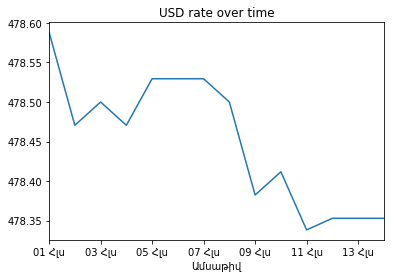

In [33]:
data.groupby("Ամսաթիվ")["Վաճ."].mean().plot(title="USD rate over time")